In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!python -V

Python 3.12.2


In [3]:
!which python

/home/teslim404/miniconda3/bin/python


In [4]:
# # Install a pip package in the current Jupyter kernel
# !pip install numpy pandas seaborn matplotlib

# Load Library

In [5]:
import os
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
print(f'cwd: {os.getcwd()}')

cwd: /home/teslim404/mlops-zoomcamp/01-intro


In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

# Read Data

In [8]:
# save model: check if directory exist. if yes, skip else create new one
data_directory = 'data/'
if os.path.exists(data_directory):
    print("Directory exists")
else:
    os.mkdir(data_directory)
    print("Directory does not exist")

Directory exists


In [9]:
# Download files
os.chdir(f'./{data_directory}')
if not os.path.exists('yellow_tripdata_2023-01.parquet'):
    !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
if not os.path.exists('yellow_tripdata_2023-02.parquet'):
    !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
os.chdir(f'../')

In [11]:
df = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')
print(len(df.columns), len(df))
df.head()

19 2913955


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


# Analyze Data

In [12]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime # get duration of ride
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) # convert to mins

df.duration.describe()

count    2.913955e+06
mean     1.601591e+01
std      4.284210e+01
min     -4.361667e+01
25%      7.250000e+00
50%      1.180000e+01
75%      1.876667e+01
max      7.053617e+03
Name: duration, dtype: float64

In [ ]:
sns.histplot(df.duration, label='Data')

plt.legend()

In [11]:
df = df[(df.duration >= 1) & (df.duration <= 60)] # take only the duration between 1 and 60

categorical = ['PULocationID', 'DOLocationID'] # categorical variables
numerical = ['trip_distance'] # numerical variables

df[categorical] = df[categorical].astype(str) # assign str to numerical variable
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [12]:
print(df.columns)

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')


In [13]:
df[categorical+numerical].head()

,PULocationID,DOLocationID,trip_distance
0,43,151,1.01
1,166,239,2.53
2,41,42,1.12
3,168,75,1.99
7,75,75,0.45


In [14]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
train_dicts

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48},
 {'PULocationID': '42', 'DOLocationID': '41', 'trip_distance': 0.9},
 {'PULocationID': '74', 'DOLocationID': '116', 'trip_distance': 2.08},
 {'PULocationID': '116', 'DOLocationID': '143', 'trip_distance': 4.64},
 {'PULocationID': '75', 'DOLocationID': '42', 'trip_distance': 1.68},
 {'PULo

# Train & Evaluate Model

In [15]:
dv = DictVectorizer() # transform lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/teslim404/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799828864

<Axes: ylabel='Count'>

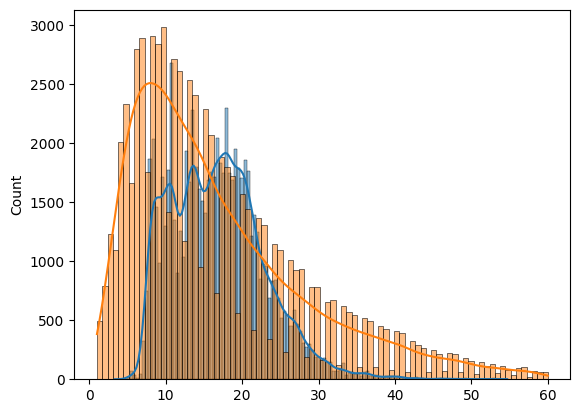

In [16]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual', kde=True)

# Merge the above into 1 function

In [17]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [19]:
len(df_train), len(df_val)

(73908, 61921)

In [20]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667,75_75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000,81_90
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000,35_213
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000,74_69
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000,168_215


In [22]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/teslim404/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715208644927

# Save model

In [24]:
# save model: check if directory exist. if yes, skip else create new one
directory = 'models'
if os.path.exists(directory):
    print("Directory exists")
else:
    os.mkdir(directory)
    print("Directory does not exist")

Directory does not exist


In [25]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)